# PINN Demo with KFAC
This notebook solves a simple PDE using `KFACPINNSolver`.

In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
from bsde_dsgE.optim import KFACPINNSolver


In [2]:
# Define PDE residual for y''(x) + y(x) = 0 with y(0)=y(pi)=0

def pinn_loss(net: eqx.Module, x: jnp.ndarray) -> jnp.ndarray:
    def y_fn(x_scalar):
        return net(jnp.array([x_scalar]))[0]
    dy_dx = jax.vmap(jax.grad(y_fn))(x[:, 0])
    d2y_dx2 = jax.vmap(jax.grad(jax.grad(y_fn)))(x[:, 0])
    resid = d2y_dx2 + jax.vmap(y_fn)(x[:, 0])
    bc = jnp.array([y_fn(0.0), y_fn(jnp.pi)])
    return jnp.mean(resid**2) + jnp.mean(bc**2)


In [3]:
key = jax.random.PRNGKey(0)
net = eqx.nn.MLP(in_size=1, out_size=1, width_size=32, depth=2, key=key)
solver = KFACPINNSolver(net=net, loss_fn=pinn_loss, lr=1e-2, num_steps=100)
xs = jnp.linspace(0, jnp.pi, 64).reshape(-1, 1)
losses = solver.run(xs, key)
print('final loss:', float(losses[-1]))


final loss: 864.039306640625


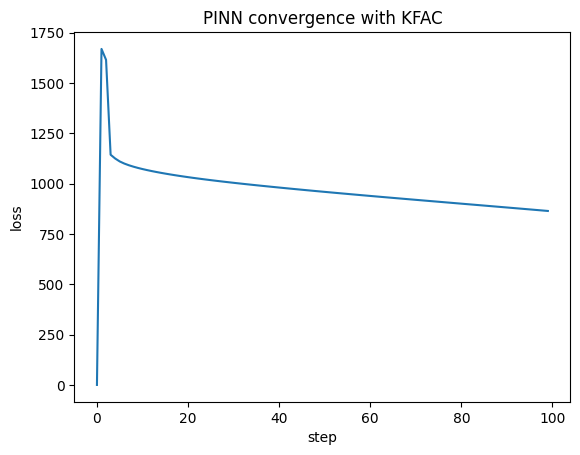

In [4]:
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss')
plt.title('PINN convergence with KFAC')
plt.show()
